#**Digikala Samsung Phones Selenium Scraper**

In [ ]:
!pip install selenium
!pip install requests
!pip install webdriver-manager

In [ ]:
!python3 digikala_crawl.py \
  --list-pages 0 \
  --per-product-pages 0 \
  --per-product-max-comments 500 \
  --debug

[DEBUG] total_pages=183
[DEBUG] enumerated 1502 product IDs from ALL mobile pages
[DEBUG] processed 20 products; reviews so far: 6681
[DEBUG] processed 40 products; reviews so far: 9304
[DEBUG] processed 60 products; reviews so far: 10917
[DEBUG] processed 80 products; reviews so far: 13354
[DEBUG] processed 100 products; reviews so far: 16866
[DEBUG] processed 120 products; reviews so far: 19582
[DEBUG] processed 140 products; reviews so far: 24056
[DEBUG] processed 160 products; reviews so far: 27254
[DEBUG] processed 180 products; reviews so far: 31393
[DEBUG] processed 200 products; reviews so far: 35383
[DEBUG] processed 220 products; reviews so far: 37958
[DEBUG] processed 240 products; reviews so far: 41228
[DEBUG] processed 260 products; reviews so far: 43153
[DEBUG] processed 280 products; reviews so far: 44939
[DEBUG] processed 300 products; reviews so far: 48824
[DEBUG] processed 320 products; reviews so far: 50676
[DEBUG] processed 340 products; reviews so far: 54171
[DEBUG

#**Data Preparation and Cleaning**

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification ,AutoModel
import torch
from shekar import Normalizer
import numpy as np

In [8]:
from google.colab import drive
drive.mount('/content/drive')
'/content/drive/My Drive'

Mounted at /content/drive


'/content/drive/My Drive'

In [5]:
digikala_comments = pd.read_csv("/content/drive/My Drive/Digikala_comments.csv")
digikala_comments.head()

,product_id,product_title,comment_id,created_at,rating,comment_text
0,17464490,گوشی موبایل سامسونگ مدل Galaxy A16 4G دو سیم ک...,79641053,14 آبان 1404,5.0,عالی بود مشکلی نداشت
1,17464490,گوشی موبایل سامسونگ مدل Galaxy A16 4G دو سیم ک...,79640652,14 آبان 1404,NaN,این گوشی گوشی زیبایی هست صفحه نمایش بزرگ و خوب...
2,17464490,گوشی موبایل سامسونگ مدل Galaxy A16 4G دو سیم ک...,79638766,14 آبان 1404,5.0,خیلی عالی \nقیمت منطقی\nکیفیت تصویر فوق‌العاده \n
3,17464490,گوشی موبایل سامسونگ مدل Galaxy A16 4G دو سیم ک...,79638757,14 آبان 1404,4.0,سرعت اینترنت پایین
4,17464490,گوشی موبایل سامسونگ مدل Galaxy A16 4G دو سیم ک...,79633595,14 آبان 1404,3.0,به معنای واقعی ی گوشی اقتصادی\nفقط براي اینکه ...


In [ ]:
digikala_product = pd.read_csv("/content/drive/My Drive/Digikala_products.csv")
digikala_product.head()

,id,title_fa,title_en,selling_price,rrp_price,rating_avg,rating_count
0,17464490,گوشی موبایل سامسونگ مدل Galaxy A16 4G دو سیم ک...,Samsung Galaxy A16 4G Dual SIM Storage 128GB A...,152752000.0,155807000.0,90.06,2256.0
1,17464125,گوشی موبایل سامسونگ مدل Galaxy A16 4G دو سیم ک...,Samsung Galaxy A16 4G Dual SIM Storage 128GB A...,128408000.0,130976000.0,89.29,1830.0
2,16552148,گوشی موبایل سامسونگ مدل Galaxy A06 دو سیم کار...,Samsung Galaxy A06 Dual SIM Storage 64GB And ...,83900000.0,85578000.0,86.01,3746.0
3,20109389,گوشی موبایل سامسونگ مدل Galaxy A07 دو سیم کارت...,Samsung Galaxy A07 Dual SIM Storage 64GB And 4...,88756000.0,90531000.0,85.76,170.0
4,19222839,گوشی موبایل سامسونگ مدل Galaxy A26 دو سیم کارت...,Samsung Galaxy A26 Dual SIM Storage 128GB And ...,194500000.0,198390000.0,86.43,420.0


In [ ]:
digikala_product.isnull().sum()

,0
id,0
title_fa,0
title_en,5
selling_price,316
rrp_price,316
rating_avg,38
rating_count,38


In [ ]:
digikala_comments.isnull().sum()

,0
product_id,0
product_title,0
comment_id,0
created_at,0
rating,3868
comment_text,0


In [ ]:
print("Shape of cooment " ,digikala_comments.shape)
print("Shape of product " ,digikala_product.shape)

Shape of cooment  (72474, 6)
Shape of product  (426, 7)


In [ ]:
print(f"there are {digikala_comments.duplicated().sum()} duplicate comments ")
print(f"there are {digikala_product.duplicated().sum()} duplicate comments ")

there are 0 duplicate comments 
there are 0 duplicate comments 


In [ ]:
print("Number Of Products In Comment Dataset",len(set(digikala_comments["product_id"])))
print("Number Of Products In Product Dataset",len(set(digikala_product["id"])))

Number Of Products In Comment Dataset 403
Number Of Products In Product Dataset 426


In [ ]:
digikala_comments.head()

,product_id,product_title,comment_id,created_at,rating,comment_text
0,17464490,گوشی موبایل سامسونگ مدل Galaxy A16 4G دو سیم ک...,79641053,14 آبان 1404,5.0,عالی بود مشکلی نداشت
1,17464490,گوشی موبایل سامسونگ مدل Galaxy A16 4G دو سیم ک...,79640652,14 آبان 1404,NaN,این گوشی گوشی زیبایی هست صفحه نمایش بزرگ و خوب...
2,17464490,گوشی موبایل سامسونگ مدل Galaxy A16 4G دو سیم ک...,79638766,14 آبان 1404,5.0,خیلی عالی \nقیمت منطقی\nکیفیت تصویر فوق‌العاده \n
3,17464490,گوشی موبایل سامسونگ مدل Galaxy A16 4G دو سیم ک...,79638757,14 آبان 1404,4.0,سرعت اینترنت پایین
4,17464490,گوشی موبایل سامسونگ مدل Galaxy A16 4G دو سیم ک...,79633595,14 آبان 1404,3.0,به معنای واقعی ی گوشی اقتصادی\nفقط براي اینکه ...


In [ ]:
digikala_product.head()

,id,title_fa,title_en,selling_price,rrp_price,rating_avg,rating_count
0,17464490,گوشی موبایل سامسونگ مدل Galaxy A16 4G دو سیم ک...,Samsung Galaxy A16 4G Dual SIM Storage 128GB A...,152752000.0,155807000.0,90.06,2256.0
1,17464125,گوشی موبایل سامسونگ مدل Galaxy A16 4G دو سیم ک...,Samsung Galaxy A16 4G Dual SIM Storage 128GB A...,128408000.0,130976000.0,89.29,1830.0
2,16552148,گوشی موبایل سامسونگ مدل Galaxy A06 دو سیم کار...,Samsung Galaxy A06 Dual SIM Storage 64GB And ...,83900000.0,85578000.0,86.01,3746.0
3,20109389,گوشی موبایل سامسونگ مدل Galaxy A07 دو سیم کارت...,Samsung Galaxy A07 Dual SIM Storage 64GB And 4...,88756000.0,90531000.0,85.76,170.0
4,19222839,گوشی موبایل سامسونگ مدل Galaxy A26 دو سیم کارت...,Samsung Galaxy A26 Dual SIM Storage 128GB And ...,194500000.0,198390000.0,86.43,420.0


In [ ]:
df = (digikala_comments[["comment_text"]].copy())

In [ ]:
df

,comment_text
0,عالی بود مشکلی نداشت
1,این گوشی گوشی زیبایی هست صفحه نمایش بزرگ و خوب...
2,خیلی عالی \nقیمت منطقی\nکیفیت تصویر فوق‌العاده \n
3,سرعت اینترنت پایین
4,به معنای واقعی ی گوشی اقتصادی\nفقط براي اینکه ...
...,...
72469,نسبت به قیمتش خوبه، فقط در جریان باشین هندیه
72470,عالی بود ممنون
72471,گوشیه خوبیه، نسبت به قیمت.\nتوصیه میکنم.
72472,راضیم ازت a24


In [ ]:
df = df[df["comment_text"].str.len() >= 3]
df = df.drop_duplicates(subset="comment_text").reset_index(drop=True)

In [ ]:
df

,comment_text
0,عالی بود مشکلی نداشت
1,این گوشی گوشی زیبایی هست صفحه نمایش بزرگ و خوب...
2,خیلی عالی \nقیمت منطقی\nکیفیت تصویر فوق‌العاده \n
3,سرعت اینترنت پایین
4,به معنای واقعی ی گوشی اقتصادی\nفقط براي اینکه ...
...,...
59459,گوشی خوبیه رام 8 و با کیفیت. فقط گوشی که برام ...
59460,نسبت به قیمتش خوبه، فقط در جریان باشین هندیه
59461,گوشیه خوبیه، نسبت به قیمت.\nتوصیه میکنم.
59462,راضیم ازت a24


## Normalization with Shekar

In [ ]:
from shekar import Normalizer
norm = Normalizer()
df["text_norm"] = [norm(t) for t in df["comment_text"].tolist()]

In [ ]:
df

,comment_text,text_norm
0,عالی بود مشکلی نداشت,عالی بود مشکلی نداشت
1,این گوشی گوشی زیبایی هست صفحه نمایش بزرگ و خوب...,این گوشی گوشی زیبایی هست صفحه نمایش بزرگ و خوب...
2,خیلی عالی \nقیمت منطقی\nکیفیت تصویر فوق‌العاده \n,خیلی عالی\n قیمت منطقی\n کیفیت تصویر فوق‌العاده
3,سرعت اینترنت پایین,سرعت اینترنت پایین
4,به معنای واقعی ی گوشی اقتصادی\nفقط براي اینکه ...,به معنای واقعی ی گوشی اقتصادی\n فقط برای اینکه...
...,...,...
59459,گوشی خوبیه رام 8 و با کیفیت. فقط گوشی که برام ...,گوشی خوبیه رام ۸ و با کیفیت. فقط گوشی که‌برام ...
59460,نسبت به قیمتش خوبه، فقط در جریان باشین هندیه,نسبت به قیمتش خوبه، فقط در جریان باشین هندیه
59461,گوشیه خوبیه، نسبت به قیمت.\nتوصیه میکنم.,گوشیه خوبیه، نسبت به قیمت.\n توصیه می‌کنم.
59462,راضیم ازت a24,راضیم ازت a۲۴


## Sentiment Auto-Labeling of Comments with ParsBERT


In [34]:
from huggingface_hub import login
# Note : I used my personal Hugging Face access token; please use your own token.
login(token="Your Access Token")

In [ ]:
MODEL = "HooshvareLab/bert-fa-base-uncased-sentiment-deepsentipers-binary"

tok = AutoTokenizer.from_pretrained(MODEL)
mdl = AutoModelForSequenceClassification.from_pretrained(MODEL)

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

mdl.to(device).eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

In [ ]:
texts = df["text_norm"].tolist()
batch_size = 64
preds = []

with torch.no_grad():
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        enc = tok(batch, padding=True, truncation=True, max_length=256, return_tensors="pt")
        enc = {k: v.to(device) for k, v in enc.items()}
        logits = mdl(**enc).logits
        preds.append(torch.argmax(logits, dim=-1).cpu().numpy())

labels = np.concatenate(preds) if preds else np.array([], dtype="int8")
df["label"] = labels.astype("int8")
df[["text_norm", "label"]].head()


,text_norm,label
0,عالی بود مشکلی نداشت,1
1,این گوشی گوشی زیبایی هست صفحه نمایش بزرگ و خوب...,0
2,خیلی عالی\n قیمت منطقی\n کیفیت تصویر فوق‌العاده,1
3,سرعت اینترنت پایین,0
4,به معنای واقعی ی گوشی اقتصادی\n فقط برای اینکه...,1


In [ ]:
df_with_label = df[["text_norm", "label"]].rename(columns={"text_norm": "comment_text"})
df_with_label.to_csv("digikala_comments_labeled.csv", index=False, encoding="utf-8")
print("saved:", len(df_with_label), "rows -> digikala_comments_labeled.csv")

saved: 59464 rows -> digikala_comments_labeled.csv


In [16]:
df = pd.read_csv("/content/drive/My Drive/digikala_comments_labeled.csv")
df.head()

,comment_text,label
0,عالی بود مشکلی نداشت,1
1,این گوشی گوشی زیبایی هست صفحه نمایش بزرگ و خوب...,0
2,خیلی عالی\n قیمت منطقی\n کیفیت تصویر فوق‌العاده,1
3,سرعت اینترنت پایین,0
4,به معنای واقعی ی گوشی اقتصادی\n فقط برای اینکه...,1


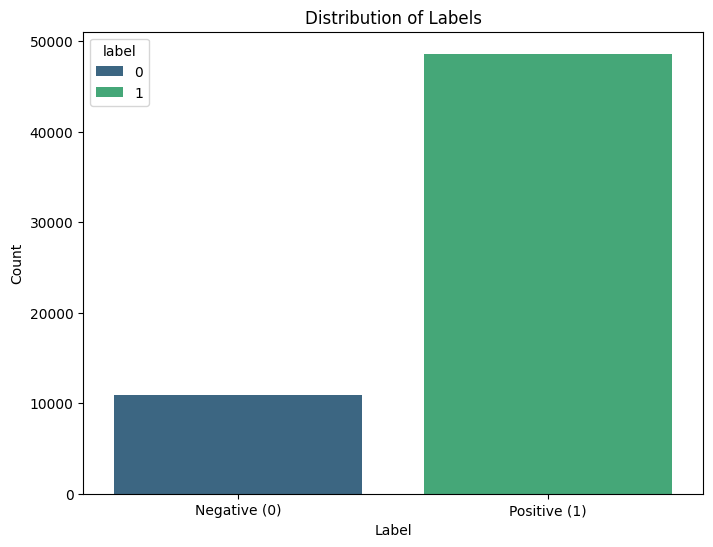

label
1    48611
0    10853
Name: count, dtype: int64


In [8]:
label_counts = df["label"].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis', hue=label_counts.index)

plt.title("Distribution of Labels")
plt.xlabel("Label")
plt.ylabel("Count")
plt.xticks([0, 1], ['Negative (0)', 'Positive (1)'])
plt.show()

print(label_counts)

#**Sentence Embeddings via ParsBERT**

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [11]:
MODEL = "HooshvareLab/bert-fa-base-uncased"
tok   = AutoTokenizer.from_pretrained(MODEL, use_fast=True)
bert  = AutoModel.from_pretrained(MODEL).to(device).eval()
bert.config.hidden_size

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/440 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/654M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/654M [00:00<?, ?B/s]

768

In [12]:
def mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    summed = (last_hidden_state * mask).sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1e-9)
    return summed / counts

def parsbert_embed(texts, batch_size=128, max_len=256, l2_norm=True):
    embs = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Embedding"):
            batch = texts[i:i+batch_size]
            enc = tok(
                batch, padding=True, truncation=True, max_length=max_len,
                return_tensors="pt"
            )
            enc = {k: v.to(device) for k, v in enc.items()}
            out = bert(**enc)
            pooled = mean_pool(out.last_hidden_state, enc["attention_mask"])
            if l2_norm:
                pooled = torch.nn.functional.normalize(pooled, p=2, dim=1)
            embs.append(pooled.cpu().numpy().astype("float32"))
    return np.vstack(embs) if embs else np.zeros((0, bert.config.hidden_size), dtype="float32")


In [14]:
texts = df["comment_text"].astype(str).tolist()

emb = parsbert_embed(
    texts,
    batch_size=128,
    max_len=256,
    l2_norm=True
)

Embedding: 100%|██████████| 465/465 [11:20<00:00,  1.46s/it]

Embeddings shape: (59464, 768)


In [20]:
print("Embeddings shape:", emb.shape)

Embeddings shape: (59464, 768)


In [10]:
import os
dir = "/content/drive/MyDrive/digikala/embeddings"
os.makedirs(dir, exist_ok=True)

In [ ]:
np.save(f"{dir}/parsbert_emb.npy", emb)

In [12]:
emb_loaded = np.load(f"{dir}/parsbert_emb.npy")

#**SVM Training & Evaluation (ParsBERT Embeddings)**

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix ,accuracy_score, precision_recall_fscore_support
import joblib
import seaborn as sns

In [17]:
X = emb_loaded.astype(np.float32)
y = df["label"].astype(int).to_numpy()

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=y, random_state=13)

In [18]:
svm = Pipeline([
    ("scaler", StandardScaler(with_mean=True)),
    ("clf", SVC(
        kernel="rbf",
        C=2.0,
        gamma="scale",
        class_weight="balanced",
        probability=False,
        shrinking=True,
        cache_size=1000,
        tol=1e-3,
        max_iter=-1
    ))
])

In [19]:
svm.fit(X_tr, y_tr)
y_pred = svm.predict(X_te)

In [21]:
print("=== Test report ===")
print(classification_report(y_te, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_te, y_pred))

=== Test report ===
              precision    recall  f1-score   support

           0      0.688     0.820     0.748      2171
           1      0.958     0.917     0.937      9722

    accuracy                          0.899     11893
   macro avg      0.823     0.869     0.843     11893
weighted avg      0.909     0.899     0.903     11893

Confusion matrix:
 [[1781  390]
 [ 807 8915]]


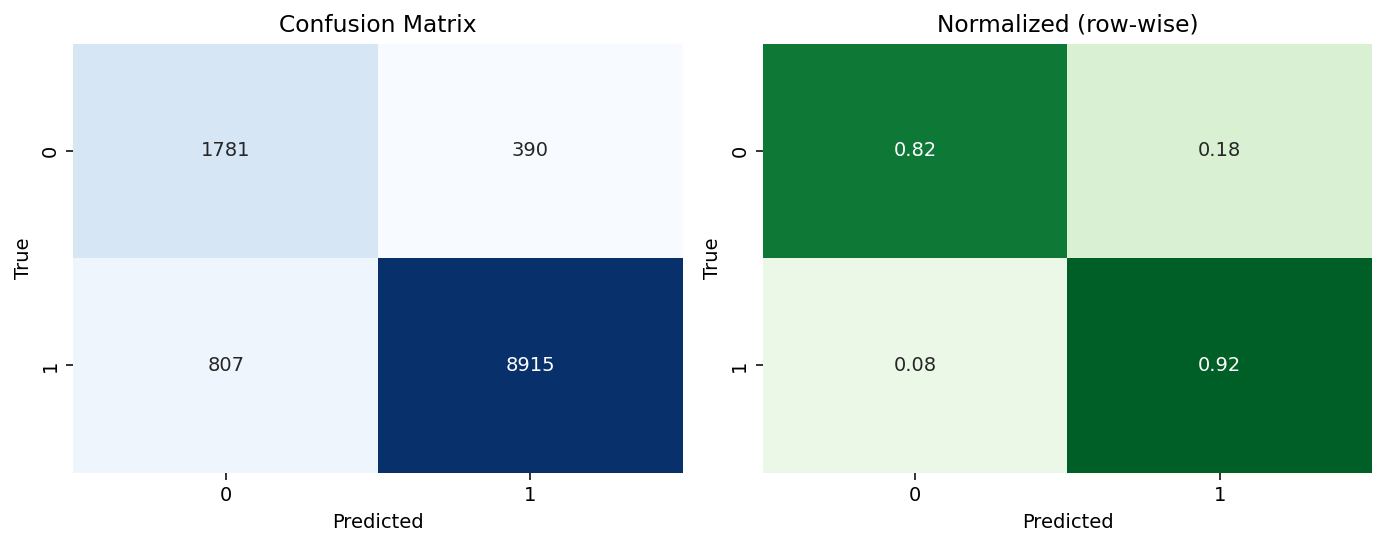

In [27]:
labels = [0, 1]
cm  = confusion_matrix(y_te, y_pred, labels=labels)
cmn = cm.astype("float") / cm.sum(axis=1, keepdims=True)

fig, axes = plt.subplots(1, 2, figsize=(10, 4), dpi=140)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=axes[0])
axes[0].set_title("Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")
axes[0].set_xticklabels(["0", "1"])
axes[0].set_yticklabels(["0", "1"])

sns.heatmap(cmn, annot=True, fmt=".2f", cmap="Greens", vmin=0, vmax=1, cbar=False, ax=axes[1])
axes[1].set_title("Normalized (row-wise)")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")
axes[1].set_xticklabels(["0", "1"])
axes[1].set_yticklabels(["0", "1"])

plt.tight_layout()
plt.show()


In [28]:
joblib.dump(svm, "/content/svm_parsbert_pipeline.pkl")
print("Saved -> /content/svm_parsbert_pipeline.pkl")

Saved -> /content/svm_parsbert_pipeline.pkl


In [30]:
from google.colab import files
files.download("/content/svm_parsbert_pipeline.pkl")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**End-to-End Sentiment Inference: Shekar → ParsBERT Embeddings → SVM**

In [31]:
def _get_device():
    if torch.backends.mps.is_available():
        return torch.device("mps")
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cpu")

def _mean_pool(last_hidden_state, attention_mask):
    mask = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
    summed = (last_hidden_state * mask).sum(dim=1)
    counts = mask.sum(dim=1).clamp(min=1e-9)
    return summed / counts

def _load_shekar_normalizer():
      from shekar import Normalizer
      return Normalizer()


class SentimentPredictor:
    def __init__(
        self,
        svm_path: str = "svm_parsbert_pipeline.pkl",
        parsbert_model: str = "HooshvareLab/bert-fa-base-uncased",
        max_len: int = 256,
        batch_size: int = 128,
        l2_norm: bool = True,
        use_fast_tokenizer: bool = True,
    ):
        self.device = _get_device()
        self.max_len = max_len
        self.batch_size = batch_size
        self.l2_norm = l2_norm

        # SVM pipeline
        self.svm = joblib.load(svm_path)

        # ParsBERT
        self.tok = AutoTokenizer.from_pretrained(parsbert_model, use_fast=use_fast_tokenizer)
        self.bert = AutoModel.from_pretrained(parsbert_model).to(self.device).eval()

        # Shekar Normalizer
        self.norm = _load_shekar_normalizer()

    def _clean_texts(self, texts):
        if self.norm is not None:
            return [self.norm(str(t).replace("\r", " ").replace("\n", " ").strip()) for t in texts]
        return [str(t).replace("\r", " ").replace("\n", " ").strip() for t in texts]

    def _embed_texts(self, texts):
        embs = []
        self.bert.eval()
        with torch.no_grad():
            for i in range(0, len(texts), self.batch_size):
                batch = texts[i:i + self.batch_size]
                enc = self.tok(
                    batch, padding=True, truncation=True, max_length=self.max_len,
                    return_tensors="pt"
                )
                enc = {k: v.to(self.device) for k, v in enc.items()}
                out = self.bert(**enc)
                pooled = _mean_pool(out.last_hidden_state, enc["attention_mask"])
                if self.l2_norm:
                    pooled = torch.nn.functional.normalize(pooled, p=2, dim=1)
                embs.append(pooled.cpu().numpy().astype("float32"))
        return np.vstack(embs) if embs else np.zeros((0, self.bert.config.hidden_size), dtype="float32")

    def predict(self, texts, return_text=False):
        if isinstance(texts, str):
            texts = [texts]

        cleaned = self._clean_texts(texts)
        X = self._embed_texts(cleaned)
        y = self.svm.predict(X).astype(np.int8)

        if return_text:
            return cleaned, y
        return y

    def predict_with_labels(self, texts, pos_label="Positive", neg_label="Negative"):
        y = self.predict(texts)
        id2lbl = {0: neg_label, 1: pos_label}
        return [id2lbl[int(v)] for v in y]


In [47]:
svm_path = "/content/svm_parsbert_pipeline.pkl"

pred = SentimentPredictor(
    svm_path=svm_path,
    parsbert_model="HooshvareLab/bert-fa-base-uncased",
    max_len=256,
    batch_size=128,
    l2_norm=True
)

texts = [
    "این گوشی فوق‌العاده‌ست، خیلی راضی‌ام.",
    "واقعاً بد بود، اصلاً ارزش خرید نداشت.",
    "گوشی خوبی نیست",
    "از نظر سخت افزار گوشی ضعیفیه",
    "سریعه، زود شارژ میشه و بازی هارو خوب اجرا میکنه",
    "یکی از بهترین گوشیهای میان رده است که بیشتر از قیمتش ارزش داره",
    "در زمان راه اندازی همون ابتدای کار، توی یه صفحه گیر کرد و ران نشد. درخواست مرجوعی زدم ولی دیجی کالا قبول نکرد. به پشتیبانی هماهنگ مراجعه کردم و همون موقع برام راه اندازی کردن. تمام این فرایند دو هفته طول کشید یعنی از زمانی که هزینه گوشی رو پرداخت کردم تا وقتی که تونستم ازش استفاده کنم. در کل از فرایند خریدم راضی نبودم. وزن گوشی هم اذیت کننده ست و بعد از دو سه هفته استفاده هنوز بهش عادت نکردم. قیمتش هم 21 تومن بود."
]
labels = pred.predict_with_labels(texts)

for i in range(len(texts)):
    print(f"Text: {texts[i]} -> Label: {labels[i]}")

Text: این گوشی فوق‌العاده‌ست، خیلی راضی‌ام. -> Label: Positive
Text: واقعاً بد بود، اصلاً ارزش خرید نداشت. -> Label: Negative
Text: گوشی خوبی نیست -> Label: Negative
Text: از نظر سخت افزار گوشی ضعیفیه -> Label: Negative
Text: سریعه، زود شارژ میشه و بازی هارو خوب اجرا میکنه -> Label: Positive
Text: یکی از بهترین گوشیهای میان رده است که بیشتر از قیمتش ارزش داره -> Label: Positive
Text: در زمان راه اندازی همون ابتدای کار، توی یه صفحه گیر کرد و ران نشد. درخواست مرجوعی زدم ولی دیجی کالا قبول نکرد. به پشتیبانی هماهنگ مراجعه کردم و همون موقع برام راه اندازی کردن. تمام این فرایند دو هفته طول کشید یعنی از زمانی که هزینه گوشی رو پرداخت کردم تا وقتی که تونستم ازش استفاده کنم. در کل از فرایند خریدم راضی نبودم. وزن گوشی هم اذیت کننده ست و بعد از دو سه هفته استفاده هنوز بهش عادت نکردم. قیمتش هم 21 تومن بود. -> Label: Negative
